<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/Samples/Brain_Failure_Prediction/Brain_Failure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to explore the Vectice integration to BigQuery  and build models to better estimate the probability of suffering a stroke based on many variables related to various Healthy and Unhealthy habits.

## Installing vectice and the other required packages

In order to keep the Vectice library lite, we install just the primary dependencies and let the user install the the other dependencies when needed. Here, we install github because our notebook is on Github and we are going to need the github package to be able to point to the notebook from the Vectice UI. You have to add the other dependencies (gitlab, bitbucket) if you're going to use them (!pip install -q "vectice[github, gitlab, bitbucket]")


In [ ]:
!pip install --q numpy pandas sklearn xgboost  imblearn
!pip install --q vectice[github]
!pip install --q fsspec
!pip install --q gcsfs 

In [ ]:
!pip show vectice

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #visualization of the variables
import os
import imblearn
from scipy.stats import chi2_contingency, ttest_ind

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import logging
from vectice import Experiment
from vectice.api.json import JobType
from vectice.api.json import ModelType
from vectice.api.json import ModelVersionStatus

# Stroke Prediction Research:
The main question is that we want to understand how the predictor variables can help estimate the probability of suffering a stroke.

## Is there other than age relationship?
Does having a heart disease or high BMI and glucose level related to have a higher change of suffering a stroke?
Plans:
We should visualize a distribution of the target variable, which is the stroke, then a distribution of variables in respect to the target variable.

Split the model into categorial features and objects. - Done. Do Hot encoding?
Call the distributions on an object based way e.g. fig, ax.
Continue building on the models. Next XGBoost.
Predict, predict, predict.
Draw final conclusions.
Add an index to notebook.
Add more distribution visualizations.
Models:
Logistic regression, random forest and xgboost.

## Exploratory Data Analysis (EDA)
It's nothing but a data exploration technique to understand the various aspects of the data. The idea is to check for relationship between variables and to check their distributions.

It follows a systematic set of steps to explore the data in the most efficient way possible

## Steps:

- Understand the Data

- Clean up the Data

- Analysis of relationships between variables

## Credentials Setup:
The Vectice API Endpoint and Token are needed to connect to the Vectice UI. Furthermore, a Google Cloud Storage credential JSON is needed to connect to the Google Cloud Storage to retrieve and upload the datasets. A project id links the runs to the relevant project and it's needed to create runs.

In [ ]:
# Upload your GCS Storage json for access to GCS
from google.colab import files
uploaded = files.upload()

Saving readerKey.json to readerKey.json


In [ ]:
# The GCS permissions scope
SCOPES = ['https://www.googleapis.com/auth/bigquery.readonly']
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "readerKey.json"  

# Specify the API endpoint for Vectice.
# You can specify your API endpoint here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_ENDPOINT']= "app.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "My API Keys" section under your profile's picture
# You can specify your API Token here in the notebook, but we recommand you to add it to a .env file
os.environ['VECTICE_API_TOKEN'] = "Your API Token"

# Add you project id. The project id can be found in the project settings page in the Vectice UI
PROJECT_ID = ID

In [ ]:
from google.cloud import bigquery

# Big Query Project ID
bq_project_id = "nodal-unity-277700"

## Getting the data from BigQuery

In [ ]:
# Client connection to Big Query
client = bigquery.Client(project=bq_project_id)

df = client.query('''SELECT * FROM `nodal-unity-277700.healthcareData.StrokeData`''')

data = df.to_dataframe()
data.head(5)

In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,64128,Male,10.0,0,0,False,children,Urban,63.08,20.5,smokes,0
1,4833,Female,12.0,0,0,False,children,Rural,207.45,25.4,smokes,0
2,42821,Female,13.0,0,0,False,Private,Rural,60.69,24,smokes,0
3,37395,Female,16.0,0,0,False,Private,Urban,63.63,20,smokes,0
4,63312,Male,16.0,0,0,False,Private,Urban,80.55,23.5,smokes,0


In [ ]:
data['bmi'] = pd.to_numeric(data['bmi'], errors='coerce')

In [ ]:
#Categorical info
cat_feat = [i for i in data.columns if data[i].dtype == 'object' or data[i].dtype == 'bool']
cat_feat

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
#remove categorial data from our set to create the model. Can be added encoded later in the process.
num_feat = data.drop(cat_feat, axis = 1)

In [ ]:
data.shape

(5110, 12)

In [ ]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
# The ID column is useless for the analysis, so we drop it
num_feat = num_feat.drop('id', axis = 1)

In [ ]:
# num_feat.groupby(num_feat['bmi'].isnull()).mean()
num_feat.isna().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
stroke                 0
dtype: int64

In [ ]:
# 97.6 BMI? That is odd, but it is what the "max" value shows us. Let's find out how many occurrences there are
num_feat[num_feat['bmi']==97.6]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
1331,17.0,1,0,61.67,97.6,0


In [ ]:
data[data['bmi']==97.6]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1331,56420,Male,17.0,1,0,False,Private,Rural,61.67,97.6,Unknown,0


In [ ]:
num_feat = num_feat[num_feat['bmi']!=97.6]

In [ ]:
#Checking again
num_feat[num_feat['bmi']>40] #sort_values('bmi')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
39,22.0,0,0,73.50,41.3,0
41,22.0,0,0,102.00,40.4,0
44,23.0,1,0,70.03,78.0,0
67,24.0,0,0,83.10,42.5,0
79,25.0,0,0,108.82,41.3,0
...,...,...,...,...,...,...
4950,66.0,1,0,205.01,52.7,0
4954,66.0,0,1,196.58,41.9,0
4961,70.0,1,0,242.52,45.5,1
4971,70.0,0,1,93.02,40.2,0


In [ ]:
num_feat.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.000000,5109.000000
mean,43.231748,0.097279,0.054022,106.156383,28.879238,0.048738
std,22.611882,0.296367,0.226084,45.283716,7.793377,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.260000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.890000,28.050000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [ ]:
num_feat.groupby('stroke').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.976683,0.088683,0.047119,104.804387,28.808427
1,67.728193,0.265060,0.188755,132.544739,30.471292


In [ ]:
num_feat.groupby(num_feat.bmi > 40)[['stroke', 'hypertension', 'heart_disease']].sum()

,stroke,hypertension,heart_disease
bmi,,,
False,231,429,264
True,18,68,12


In [ ]:
bmi_over_40 = num_feat[num_feat['bmi'] > 40 ]

In [ ]:
bmi_over_40[num_feat['stroke'] == 1 ].sort_values(by='age')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
1939,43.0,0,0,143.43,45.9,1
3697,45.0,0,0,224.10,56.6,1
4769,47.0,0,0,86.94,41.1,1
4796,51.0,1,0,112.16,42.5,1
3131,52.0,1,0,233.29,48.9,1
3825,53.0,0,0,64.17,41.5,1
347,54.0,0,0,191.82,40.4,1
4492,56.0,0,0,185.17,40.4,1
672,57.0,1,0,212.08,44.2,1
2072,59.0,0,0,96.16,44.1,1


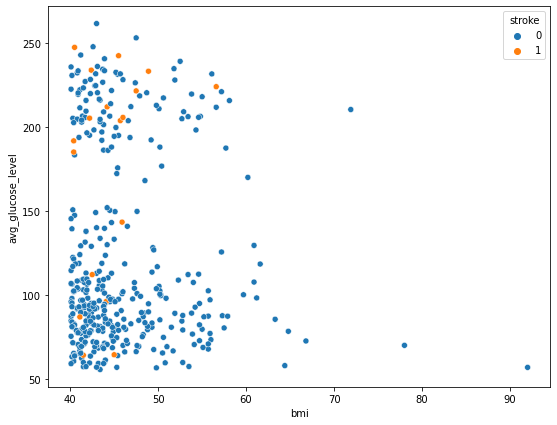

In [ ]:
plt.figure(figsize = (9,7))
sns.scatterplot(x = 'bmi', y = 'avg_glucose_level', hue = 'stroke', data =bmi_over_40)
plt.show()

Adult Body Mass Index (BMI)¶
BMI does not measure body fat directly, but research has shown that BMI is moderately correlated with more direct measures of body fat obtained from skinfold thickness measurements, bioelectrical impedance, underwater weighing, dual energy x-ray absorptiometry (DXA) and other methods 1,2,3. Furthermore, BMI appears to be strongly correlated with various adverse health outcomes consistent with these more direct measures of body fatness

In [ ]:
#check for unique values
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

It seems the majorities of values are binaries, which mean that they are categorical values e.g. "yes" or "no" except for gender which is says it has 3 types. We need to check if that is not because a typo or blank entries.

The categorial variables with more different values are the following in ascending order:

smoking_status 4
work_type 5

In [ ]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
data = data[data['gender']!='Other']

In [ ]:
data.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [ ]:
data[data['smoking_status'] == 'Unknown']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
789,5010,Female,2.00,0,0,False,children,Rural,92.48,18.0,Unknown,0
790,15274,Female,2.00,0,0,False,children,Rural,79.89,31.6,Unknown,0
791,8320,Male,2.00,0,0,False,children,Rural,73.62,20.8,Unknown,0
792,14387,Male,2.00,0,0,False,children,Urban,93.88,17.4,Unknown,0
793,65218,Male,2.00,0,0,False,children,Rural,109.10,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2328,69435,Female,0.56,0,0,False,children,Urban,80.92,18.3,Unknown,0
2329,47848,Male,1.56,0,0,False,children,Rural,93.74,20.1,Unknown,0
2330,16061,Female,1.56,0,0,False,children,Urban,113.40,19.5,Unknown,0
2331,41042,Female,1.56,0,0,False,children,Urban,71.81,22.6,Unknown,0


In [ ]:
#smokers and goverment jobs
smokers = data[data['smoking_status']=='smokes']

smokers.work_type.value_counts(normalize=True)

Private          0.688213
Self-employed    0.157161
Govt_job         0.152091
children         0.002535
Name: work_type, dtype: float64

In [ ]:
smokers['age'].groupby(smokers['age']).count()

age
10.0    1
12.0    1
13.0    1
16.0    2
17.0    4
       ..
78.0    7
79.0    9
80.0    7
81.0    5
82.0    6
Name: age, Length: 70, dtype: int64

### Creating an Experiment

In [ ]:
## Create an Experiment instance to start creating runs in Vectice
## We create our experiment for data preparation and specify the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
from vectice import Experiment
logging.basicConfig(level=logging.INFO)
experiment = Experiment(job='Brain Imaging Data Cleaning',job_type=JobType.PREPARATION,project_token=PROJECT_ID, auto_code=True)

INFO:vectice.auth:Vectice: Refreshing token... 
INFO:vectice.auth:Success!
INFO:vectice.auth:Vectice: Validating project token... 
INFO:vectice.auth:The entered token is OK, and allows you to work on the 'Brain Failure Prediction' Project, part of the 'Sample - Everyone' Workspace


### Creating the experiment run inputs

In [ ]:
# Because we are using Colab in this tutorial example we are going to declare a reference to the code
## manually. This will be added as a reference to the run we are going to create next.
# If you are using your local environment with GIT installed or JupyterLab etc... the code
# tracking is automated.
uri = "https://github.com/vectice/vectice-examples"
entrypoint = "Samples/Brain_Failure_Prediction/Brain_Failure_Prediction.ipynb"
input_code = experiment.add_code_version_uri(uri=uri, entrypoint=entrypoint)

In [ ]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically.
input_ds = experiment.add_dataset_version("Brain Imaging Data")

### Starting the Experiment run

In [ ]:
inputs = [input_ds, input_code]
# All the artifacts created before starting the run experiment, will be attached as inputs of the run
# The created dataset version and code version will be automatically attached as inputs of the run
experiment.start()
# All the artifacts created after starting the run experiment, will be attached as outputs of the run

In [ ]:
#handling missing values
data['bmi'] = data['bmi'].fillna(round (data['bmi'].median(), 2))
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## Uploading the cleaned data into BigQuery

Upload the cleaned data to BigQuery requires having writing rights in the service accounts. As the provided service account has only reading rights, we already uploaded the cleaned data for you.
If you have a service account with reading rights, you uncomment the following cell and rn it.

In [ ]:
# Uploading the cleaned data into BigQuery
# TODO(developer): Set table_id to the ID of the table to create.

#table_id = "nodal-unity-277700.healthcareData.StrokeDataClean"

# The job_config holds schema information. Column names, data types etc. 

#job_config = bigquery.LoadJobConfig(
#    schema=[bigquery.SchemaField(col, str(data[col].dtype if data[col].dtype != 'object' else "STRING")) for col in data.columns],)

#load_job = client.load_table_from_dataframe(data, table_id, job_config=job_config)  # Make an API request.

#load_job.result()  # Waits for the job to complete.

#destination_table = client.get_table(table_id)  # Make an API request.
#print("Loaded {} rows.".format(destination_table.num_rows))

In [ ]:
# Creating the new dataset as an output for the run , everything that comes after experiment.start() and before experiment.complete()
# is by default an output artifact  
experiment.add_dataset_version(dataset="Cleaned Brain Imaging Data",properties={"Fillna": "Median"})

experiment.complete()

7519

In [ ]:
correlation = data.drop('id', axis = 1).corr()

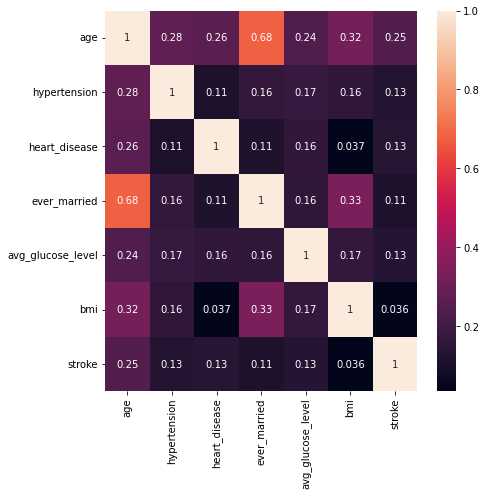

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(correlation, xticklabels =correlation.columns, yticklabels = correlation.columns, annot=True)
plt.show()

As we can see it looks that the more related variable to stroke is the age feature. We may consider to use a model to only use the wanted variables to remove id for example.

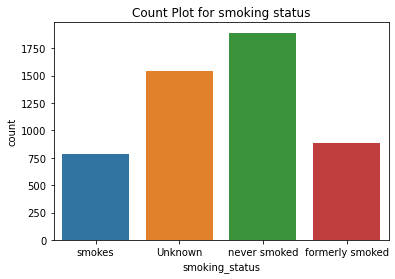

In [ ]:
sns.countplot(x = 'smoking_status', data = data)
plt.title("Count Plot for smoking status")
plt.show()

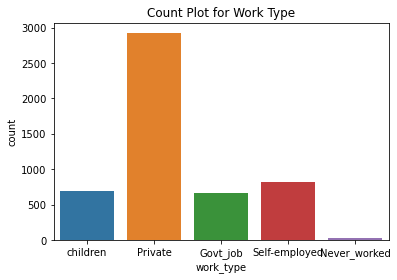

In [ ]:
sns.countplot(x = 'work_type', data = data)
plt.title('Count Plot for Work Type')
plt.show()

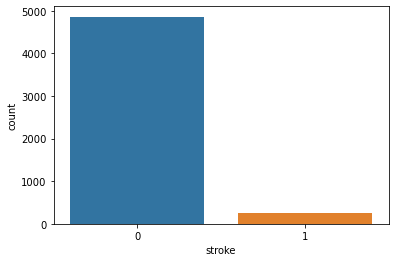

In [ ]:
#Ploting the distribution of Stroke
num_data = num_feat
sns.countplot(x='stroke', data=num_data)
plt.show()

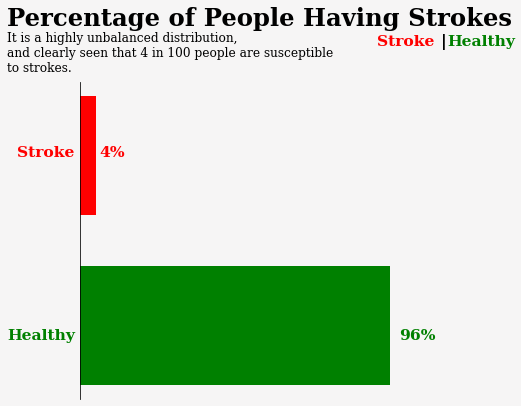

In [ ]:
x = pd.DataFrame(num_data.groupby(['stroke'])['stroke'].count())

# plot
fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
ax.barh([1], x.stroke[1], height = 0.7, color = 'red')
plt.text(-1150,-0.08, 'Healthy',{'fontfamily': 'Serif','weight':'bold','Size': '16','style':'normal', 'color':'green'})
#plt.text(5000,-0.08, '95%',{'font':'Serif','weight':'bold' ,'size':'16','color':'green'})
plt.text(5000,-0.08, f"{(num_data.shape[0]/num_data.shape[0]*100) - (x.shape[0]/(num_data.shape[0])*100)*100:.0f}%" ,{'fontfamily':'Serif','weight':'bold' ,'size':'16','color':'green'})
ax.barh([0], x.stroke[0], height = 0.7, color = 'green')
plt.text(-1000,1, 'Stroke', {'fontfamily': 'Serif','weight':'bold','Size': '16','style':'normal', 'color':'red'})
plt.text(300,1, f"{((x.shape[0]/data.shape[0])*100)*100:.0f}%",{'fontfamily':'Serif', 'weight':'bold','size':'16','color':'red'})

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

plt.text(-1150,1.77, 'Percentage of People Having Strokes' ,{'fontfamily': 'Serif', 'Size': '25','weight':'bold', 'color':'black'})
plt.text(4650,1.65, 'Stroke ', {'fontfamily': 'Serif','weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'red'})
plt.text(5650,1.65, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(5750,1.65, 'Healthy', {'fontfamily': 'Serif','weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'green'})
plt.text(-1150,1.5, 'It is a highly unbalanced distribution,\nand clearly seen that 4 in 100 people are susceptible \nto strokes.', 
        {'fontfamily':'Serif', 'size':'12.5','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

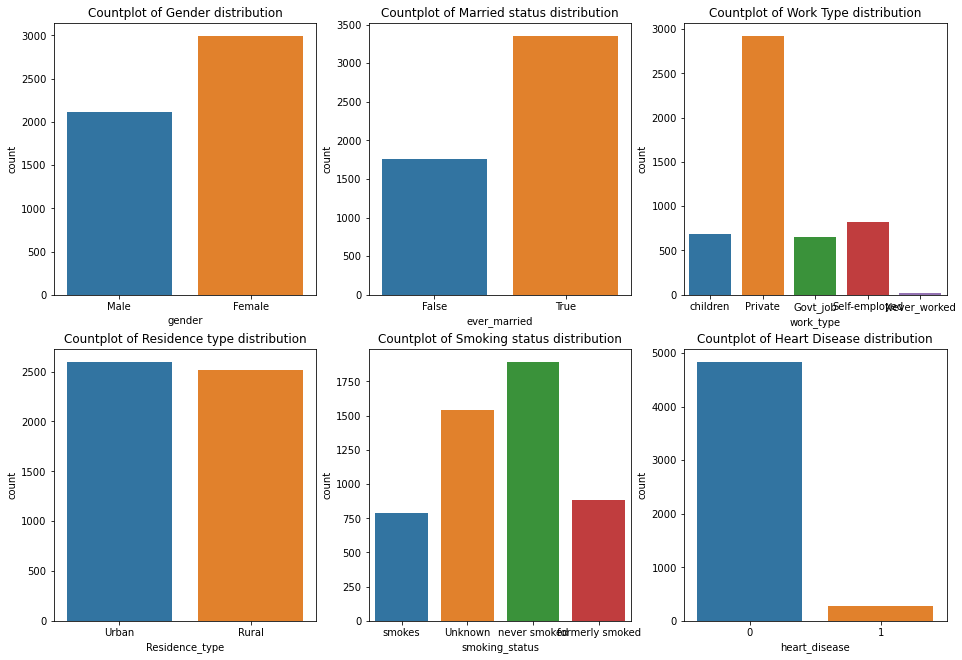

In [ ]:
plt.figure(figsize = (16,11))
plt.subplot(2,3,1)
sns.countplot(x = 'gender', data = data)
plt.title('Countplot of Gender distribution')

plt.subplot(2,3,2)
sns.countplot(x = 'ever_married', data = data)
plt.title('Countplot of Married status distribution')

plt.subplot(2,3,3)
sns.countplot(x='work_type', data = data)
plt.title('Countplot of Work Type distribution')

plt.subplot(2,3,4)
sns.countplot(x = 'Residence_type', data = data)
plt.title('Countplot of Residence type distribution')

plt.subplot(2,3,5)
sns.countplot(x = 'smoking_status',data = data)
plt.title('Countplot of Smoking status distribution')

plt.subplot(2,3,6)
sns.countplot(x = 'heart_disease',data = data)
plt.title('Countplot of Heart Disease distribution')
plt.show()

In [ ]:
num_data = num_feat
#handling missing values
num_data['bmi'] = num_data['bmi'].fillna(round (num_data['bmi'].median(), 2))

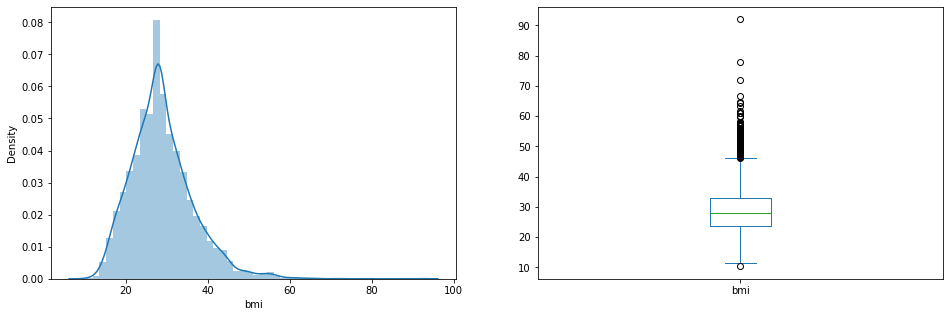

In [ ]:
# Checking the distribution of the predictor variables. 
# Here, we will use both distplot and boxplot as shown below. 
# Let us plot each variable to show its distribution in the dataset.
#fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
plt.figure(1)
plt.title('BMI Distribution before droping the abnormal entry')
plt.subplot(121), sns.distplot(num_data['bmi'])
plt.subplot(122), num_data['bmi'].plot.box(figsize=(16,5))
plt.show()

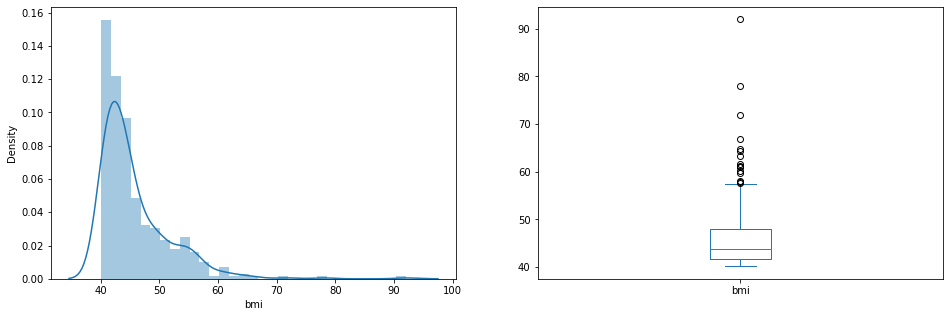

In [ ]:
plt.figure(1)
plt.title('Stroke Distribution with BMI over 40')
plt.subplot(121), sns.distplot(bmi_over_40['bmi'])
plt.subplot(122), bmi_over_40['bmi'].plot.box(figsize=(16,5))
plt.show()

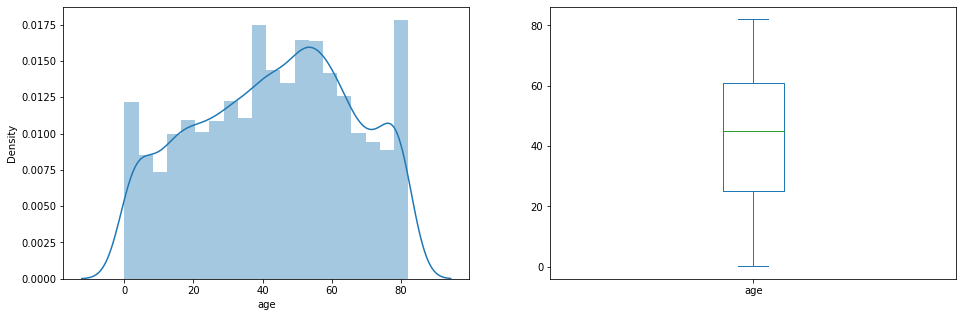

In [ ]:
plt.figure(1)
plt.subplot(121), sns.distplot(data['age'])
plt.subplot(122), data['age'].plot.box(figsize=(16,5))
plt.show()

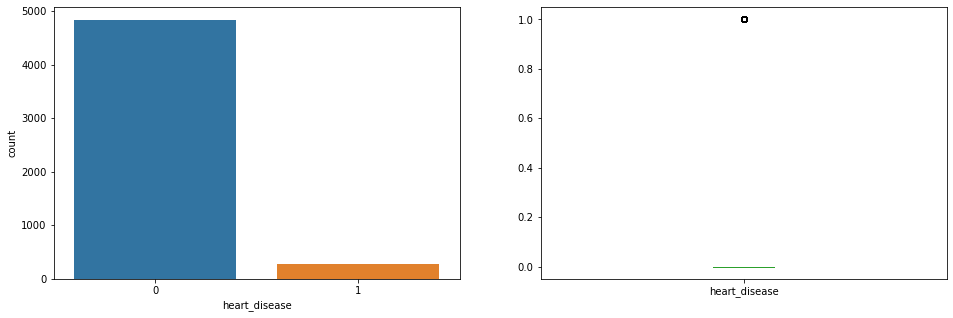

In [ ]:
plt.figure(1)
plt.subplot(121), sns.countplot(data['heart_disease'])
plt.subplot(122), data['heart_disease'].plot.box(figsize=(16,5))
plt.show()

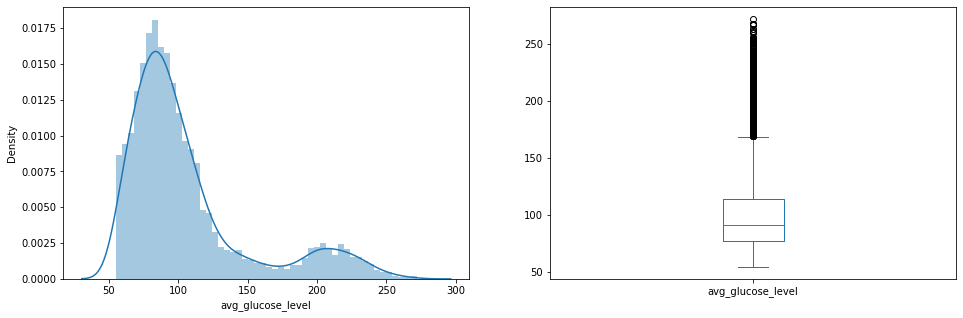

In [ ]:
plt.figure(1)
plt.subplot(121), sns.distplot(data['avg_glucose_level'])
plt.subplot(122), data['avg_glucose_level'].plot.box(figsize=(16,5))
plt.show()

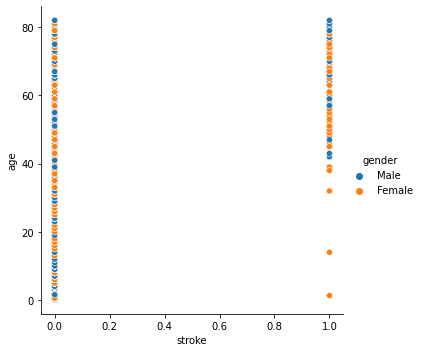

In [ ]:
sns.relplot(x='stroke', y='age', hue='gender', data=data ) 
plt.show()

With this it seems that a confusion matrix and a logistic regression may have a better relationship because this is showing that there is not a linear relationship.

From this bar chart we can clearly see that for people over 40 years old the majority suffered a stroke. We have an uptick at age 40 then it drops until about age 55 through 65 and drops again and goes all the way up at age 80.

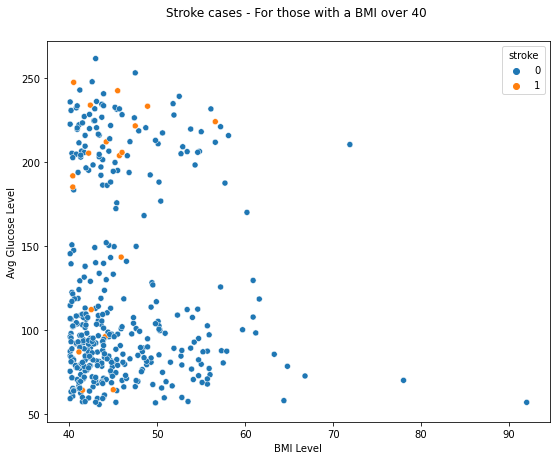

In [ ]:
# Scatter Plot
plt.figure(figsize = (9,7))
sns.scatterplot(x = 'bmi', y = 'avg_glucose_level', hue = 'stroke', data =bmi_over_40)
plt.title('Stroke cases - For those with a BMI over 40 ',y=1.05)

plt.xlabel('BMI Level')
plt.ylabel('Avg Glucose Level')
plt.show()

# Hypothesis Testing

In [ ]:
def chi2_dependency(data_df, x,y):
    ctab = pd.crosstab(data_df[x], data_df[y])
    stat, p, dof, expected = chi2_contingency(ctab)
    alpha1 = 0.05
    alpha2 = 0.01
    print('--------------Chi Squared Hypothesis Test Results-------------------')
    print('Variable X: ',x)
    print('Variable Y: ',y)
    if p<alpha1 and p > alpha2:
        print('P-value: ',p)
        print('We reject the NUll Hypothesis H0')
        print('There is some evidence to suggest that {} and {} are dependent'.format(x,y))
    if p < alpha1 and p < alpha2:
        print('P-value: ',p)
        print('We reject the NUll Hypothesis H0')
        print('There is substantial evidence to suggest that {} and {} are dependent'.format(x,y))
    else:
        print('P-value: ',p)
        print('We fail to reject the NUll Hypothesis H0')
        print('There is no evidence to suggest that {} and {} are independent'.format(x,y))
        
    print()

In [ ]:
chi2_dependency(data,'gender','stroke')
chi2_dependency(data,'ever_married','stroke')
chi2_dependency(data,'hypertension','stroke')
chi2_dependency(data,'heart_disease','stroke')
chi2_dependency(data,'work_type','stroke')
chi2_dependency(data,'Residence_type','stroke')
chi2_dependency(data,'smoking_status','stroke')

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  gender
Variable Y:  stroke
P-value:  0.5598277580669416
We fail to reject the NUll Hypothesis H0
There is no evidence to suggest that gender and stroke are independent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  ever_married
Variable Y:  stroke
P-value:  1.6862856191673454e-14
We reject the NUll Hypothesis H0
There is substantial evidence to suggest that ever_married and stroke are dependent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  hypertension
Variable Y:  stroke
P-value:  1.688936253410575e-19
We reject the NUll Hypothesis H0
There is substantial evidence to suggest that hypertension and stroke are dependent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  heart_disease
Variable Y:  stroke
P-value:  2.120831133146208e-21
We reject the NUll Hypothesis H0
There is substantial evidence to sugg

Gender and Residential Type do not seem to have an impact on stroke
Smoking Status, Work Type, Heart Disease, Hypertension and Married status have an impact on stroke

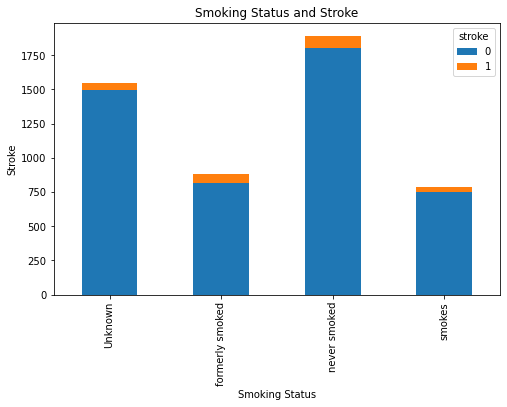

In [ ]:
ctab = pd.crosstab(data['smoking_status'], data['stroke'])


ctab.plot.bar(stacked = True, figsize = (8,5))
plt.xlabel('Smoking Status')
plt.ylabel('Stroke')
plt.title('Smoking Status and Stroke')
plt.show()

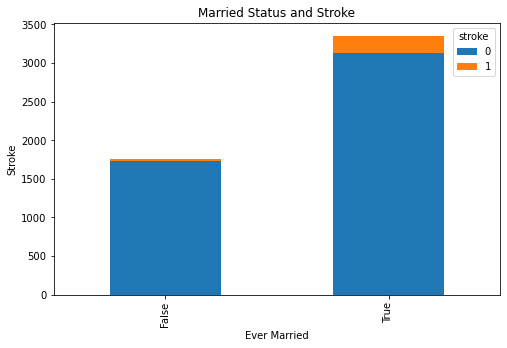

Ratio of stroke affected from ever_married class 0.07426185505517446
Ratio of stroke affected from never married class 0.1417995444191344


In [ ]:
ctab = pd.crosstab(data['ever_married'], data['stroke'])

ctab.plot.bar(stacked = True, figsize = (8,5))
plt.xlabel('Ever Married')
plt.ylabel('Stroke')
plt.title('Married Status and Stroke')
plt.show()

print('Ratio of stroke affected from ever_married class',
      len(data[data['stroke']==1])/len(data[data['ever_married']==True]))
      
print('Ratio of stroke affected from never married class',
      len(data[data['stroke']==1])/len(data[data['ever_married']==False]))

In [ ]:
target_col = ['stroke']
num_cols = ['id', 'age', 'avg_glucose_level', 'bmi']
cat_cols = [col for col in data.columns if col not in num_cols+target_col]

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
data['ever_married'] = label_encoder.fit_transform(data['ever_married'])
data['Residence_type'] = label_encoder.fit_transform(data['Residence_type'])

In [ ]:
data = pd.get_dummies(data, prefix = ['work_type'], columns = ['work_type'])
data = pd.get_dummies(data, prefix = ['smoking_status'], columns = ['smoking_status'])

In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,64128,1,10.0,0,0,0,1,63.08,20.5,0,0,0,0,0,1,0,0,0,1
1,4833,0,12.0,0,0,0,0,207.45,25.4,0,0,0,0,0,1,0,0,0,1
2,42821,0,13.0,0,0,0,0,60.69,24.0,0,0,0,1,0,0,0,0,0,1
3,37395,0,16.0,0,0,0,1,63.63,20.0,0,0,0,1,0,0,0,0,0,1
4,63312,1,16.0,0,0,0,1,80.55,23.5,0,0,0,1,0,0,0,0,0,1


## Alter data to be conducive for a BigQuery ingest job

This requires having writing rights in the service accounts. As the provided service account has only reading rights, we already did the job for you.
If you have a service account with reading rights, you uncomment the following cell and rn it.

In [ ]:
# Alter data to be conducive for a BigQuery ingest job. 
names_types = [("_".join(col.split("-")) if "-" in col else "_".join(col.split(" ")), data[col].dtype if data[col].dtype != 'uint8' else "INT") for col in data.columns]
# The column names must match in the DataFrame and BigQuery ingestion. For example Big Query doesn't accept "-" in column names.
data = data.rename(columns={x:y[0] for x,y in zip(data.columns, names_types)})

# TODO(developer): Set table_id to the ID of the table to create.
table_id = "nodal-unity-277700.healthcareData.StrokeDataTraining"

job_config = bigquery.LoadJobConfig(
   schema=[bigquery.SchemaField(col, str(data[col].dtype if data[col].dtype != 'uint8' else "INT64")) for col in data.columns],)

load_job = client.load_table_from_dataframe(data, table_id, job_config=job_config)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))


Loaded 35764 rows.


## Splitting the dataset

In [ ]:
#include categorical values in the dataset
#Since we are using a Tree based model, One-Hot encoding is not an absolute necessity
#However, this dataset, train and test sets will be updated whenever one-hot encoding will be used
from sklearn.model_selection import train_test_split

#Splitting the dataset
x = data.drop('stroke', axis=1)
y = data.stroke

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.3, random_state=1)

**Before proceeding for tree based models, lets check rank of feature importance on a decision tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)

DecisionTreeClassifier()

In [ ]:
print(len(xtrain.columns.tolist()))
len(dt.feature_importances_)

18


18

<AxesSubplot:>

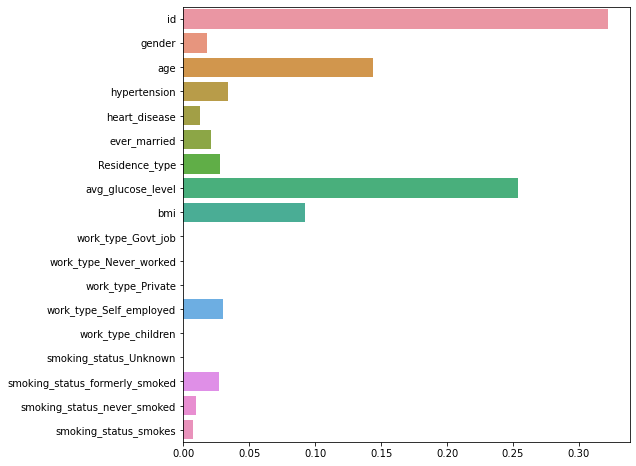

In [ ]:
plt.figure(figsize = (8,8))
sns.barplot(x = dt.feature_importances_, y = xtrain.columns.tolist())

## Modeling

ML algorithms can have a poor performance when dealing with datasets in which one or more classes represent only a small proportion of the overall dataset compared with a dominant class. This problem can be solved by balancing the number of examples between different classes. Here we suggest to use SMOTE (Synthetic Minority Over-sampling Technique) that creates synthetic data based on creating new data points that are mid-way between two near neighbours in any particular class.SMOTE is applied ONLY on the training set and not on the test set to avoid biased results.

Here we are going to models, one using the SMOTE method to balance the dataset and another one with our original data in order to compare them

In [ ]:
##SMOTE data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
xtrain_mod, ytrain_mod = sm.fit_resample(xtrain, ytrain)

Let's instanciate a new Experiment for this modeling job. 

In [ ]:
# We create our experiment for modeling and specify the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Modeling", job_type = JobType.TRAINING, project=PROJECT_ID, auto_code = True)

In the cell below, we create dataset versions that will be used as inputs for our modeling runs

In [ ]:
input_non_smote_ds = experiment.add_dataset_version("Brain Imaging Training Data")
input_smote_ds = experiment.add_dataset_version("Brain Imaging SMOTE Data")

### RandomForest

In [ ]:
#Building the model using RandomForest
from sklearn.ensemble import RandomForestClassifier
n_estimators=500
rfc = RandomForestClassifier(n_estimators)
rfc.fit(xtrain, ytrain)
preds = rfc.predict(xtest)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, preds)

array([[3396,    0],
       [ 181,    0]])

True positives are on the upper left. Then the botton right is the true negative. Which means, that I was supposed a negative and the model got a negative.

The false positive is the number on the upper right. False negative are the numbers on the bottom left.

Here we have the True negatives or 0s because we don't have many cases of strokes. Meaning that 3,388 people did not have a stroke.

On the inverse we have the True positive or 1s for those who suffered a stroke.

is the False negative, those who were predicted as 1 but they were 0s. Number 13

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score_dt = accuracy_score(ytest,preds)
accuracy_score_dt

0.9493989376572547

In [ ]:
from sklearn.metrics import f1_score
f1_score_dt = f1_score(ytest, preds, average='micro')
f1_score_dt

0.9493989376572547

In [ ]:
# Adding a version of the Random Forest Classifier to the list of Non_smote_models
experiment.start(inputs=[input_non_smote_ds, input_code], run_notes="Non-SMOTE_RandomForest", run_properties={"A run property": "A value"})
# Let's log the model we trained along with its metrics, as a new version 
# of the "Non_smote_models" model in Vectice.
metrics = {"Accuracy Score": accuracy_score_dt, "F1 Score": f1_score_dt}
model_version =  experiment.add_model_version(model="Non_smote_models", algorithm="Random Forest Classifier", metrics=metrics, hyper_parameters={"n_estimators", str(n_estimators)})
# We complete the current experiment's run 
## The created model versions will be automatically attached as an output of the run
experiment.complete()

7563

True positives are on the upper left. The botton right is for true negatives. Which means, that I was supposed a negative and the model got a negative.

The false positive is the number on the upper right. False negative are the numbers on the bottom left.

Gradient Boost Classifier
Include categorical values in the dataset. Since we are using a Tree based model, One-Hot encoding is not an absolute necessity

However, this dataset, train and test sets will be updated whenever one-hot enconding will be used

### Using GradientBoost Classifier

**Non Smote Dataset**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Adding a version of the GradientBoost Classifier to the list of Non_smote_models

experiment.start(inputs=[input_non_smote_ds, input_code], run_notes="Non-SMOTE_GradientBoost", run_properties={"A run property": "A value"})

random_state = 123
n_estimators = 500
gbc = GradientBoostingClassifier(random_state=random_state, n_estimators=n_estimators)
gbc.fit(xtrain,ytrain)

preds = gbc.predict(xtest)
print(confusion_matrix(ytest, preds))
print(classification_report(ytest, preds, output_dict = True))
accuracy_score_gbc = accuracy_score(ytest, preds)
f1_score_gbc = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "Non_smote_models" model in Vectice.

hyper_parameters = {"random_state": str(random_state), "n_estimators": str(n_estimators)}
metrics = {"Accuracy Score": accuracy_score_gbc, "F1 Score": f1_score_gbc}

model_version =  experiment.add_model_version(model="Non_smote_models", algorithm="Gradient Boosting Classifier", metrics=metrics, hyper_parameters=hyper_parameters)
# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[3356   40]
 [ 172    9]]
{'0': {'precision': 0.9512471655328798, 'recall': 0.9882214369846879, 'f1-score': 0.9693818601964183, 'support': 3396}, '1': {'precision': 0.1836734693877551, 'recall': 0.049723756906077346, 'f1-score': 0.07826086956521738, 'support': 181}, 'accuracy': 0.9407324573665082, 'macro avg': {'precision': 0.5674603174603174, 'recall': 0.5189725969453827, 'f1-score': 0.5238213648808179, 'support': 3577}, 'weighted avg': {'precision': 0.9124071210815888, 'recall': 0.9407324573665082, 'f1-score': 0.9242901913945599, 'support': 3577}}
Accuracy Score:  0.9407324573665082
F1 Score:  0.07826086956521738


7564

**Smote Dataset**

In [ ]:
## Applying on Smote Dataset

# Adding a version of the GradientBoost Classifier to the list of smote_models

experiment.start(inputs=[input_smote_ds, input_code], run_notes="SMOTE_GradientBoost", run_properties={"A run property": "A value"})


random_state = 123
n_estimators = 30
max_depth = 2
gbc2 = GradientBoostingClassifier(random_state= random_state, n_estimators=n_estimators, max_depth=max_depth)
gbc2.fit(xtrain_mod,ytrain_mod)
preds = gbc2.predict(xtest)
print(confusion_matrix(ytest, preds))

accuracy_score_gbc_smote = accuracy_score(ytest, preds)
f1_score_gbc_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "smote_models" model in Vectice.

metrics = {"Accuracy Score": accuracy_score_gbc_smote, "F1 Score": f1_score_gbc_smote}
hyper_parameters = {"random_state": str(random_state), "n_estimators": str(n_estimators), "max_depth": str(max_depth)}
model_version =  experiment.add_model_version(model="smote_models", algorithm="Gradient Boosting Classifier SMOTE", metrics=metrics, hyper_parameters=hyper_parameters)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[2873  523]
 [ 101   80]]
Accuracy Score:  0.8255521386636846
F1 Score:  0.2040816326530612


7565

### XGBoost

**Non Smote Dataset**

In [ ]:
#Fitting model on non-SMOTE dataset

# Adding a version of the XGBoost Classifier to the list of Non_smote_models
experiment.start(inputs=[input_non_smote_ds, input_code], run_notes="Non-SMOTE_XGBoost", run_properties={"A run property": "A value"})

n_estimators = 250
xgb1 = XGBClassifier(n_estimators=n_estimators)
xgb1.fit(xtrain, ytrain)
preds = xgb1.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = xgb1.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))

xgb_accuracy_score = accuracy_score(ytest, preds)
xgb_f1_score = f1_score(ytest,preds)
print('Test Accuracy Score: ', xgb_accuracy_score)
print('F1 Score: ', xgb_f1_score)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Non_smote_models" model in Vectice.
hyper_parameters = {"n_estimators": str(n_estimators)}
metrics = {"Accuracy Score": xgb_accuracy_score, "F1 Score": xgb_f1_score}
model_version =  experiment.add_model_version(model="Non_smote_models", algorithm="XGBoost", metrics=metrics,hyper_parameters=hyper_parameters)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[15:27:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[3353   43]
 [ 173    8]]
Train Accuracy Score:  1.0
Train F1 Score:  1.0
Test Accuracy Score:  0.9396142018451216
F1 Score:  0.06896551724137931


7566

**Smote Dataset**

In [ ]:
#Fitting model on SMOTE dataset

# Adding a version of the XGBoost Classifier to the list of smote_models
experiment.start(inputs=[input_smote_ds, input_code], run_notes="SMOTE_XGBoost", run_properties={"A run property": "A value"})

n_estimators = 255
reg_alpha=0.5
reg_lambda = 0.4 
max_depth= 1
xgb = XGBClassifier(n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, max_depth=max_depth)
xgb.fit(xtrain_mod, ytrain_mod)
preds = xgb.predict(xtest)
print(confusion_matrix(ytest, preds))
#print(classification_report(ytest, preds, output_dict = True))

train_preds = xgb.predict(xtrain_mod)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))

accuracy_score_xgb_smote = accuracy_score(ytest, preds)
f1_score_xgb_smote = f1_score(ytest,preds)
print('Accuracy Score: ', accuracy_score_xgb_smote)
print('F1 Score: ',f1_score_xgb_smote)

# Let's log the model we trained along with its metrics, as a new version 
# of the "smote_models" model in Vectice.
hyper_parameters = {"n_estimators": str(n_estimators), "reg_alpha": str(reg_alpha), "reg_lambda": str(reg_lambda), "max_depth": str(max_depth)}
metrics = {"Accuracy Score": accuracy_score_xgb_smote, "F1 Score": f1_score_xgb_smote}
model_version =  experiment.add_model_version(model="smote_models", algorithm="XGBoost", metrics=metrics, hyper_parameters=hyper_parameters)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[15:27:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[3248  148]
 [ 156   25]]
Train Accuracy Score:  0.9491120218579235
Train F1 Score:  0.9484963705496025
Accuracy Score:  0.9150125803746156
F1 Score:  0.14124293785310735


7567

### Gaussian Naive Bayes

**Non Smote Dataset**

In [ ]:
#Applying on non-SMOTE dataset

# Adding a version of the Naive Bayes Classifier to the list of Non_smote_models
from sklearn.naive_bayes import GaussianNB

experiment.start(inputs=[input_non_smote_ds, input_code], run_notes="Non_SMOTE_NaiveBayes", run_properties={"A run property": "A value"})

gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

preds = gnb.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = gnb.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))
accuracy_score_gnb = accuracy_score(ytest, preds)
f1_score_gnb = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "Non_smote_models" model in Vectice.
metrics = {"Accuracy Score": accuracy_score_gnb, "F1 Score": f1_score_gnb}
model_version =  experiment.add_model_version(model="Non_smote_models", algorithm="Gaussian NB", metrics=metrics)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[3237  159]
 [ 143   38]]
Train Accuracy Score:  0.9223237597911227
Train F1 Score:  0.22222222222222224
Accuracy Score:  0.915571708135309
F1 Score:  0.20105820105820105


7568

**Smote Dataset**

In [ ]:
#Applying on SMOTE dataset

# Adding a version of the Naive Bayes Classifier to the list of smote_models
from sklearn.naive_bayes import GaussianNB

experiment.start(inputs=[input_smote_ds, input_code], run_notes="SMOTE_NaiveBayes", run_properties={"A run property": "A value"})

gnb = GaussianNB()
gnb.fit(xtrain_mod, ytrain_mod)

preds = gnb.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = gnb.predict(xtrain_mod)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))
accuracy_score_gnb_smote = accuracy_score(ytest, preds)
f1_score_gnb_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "smote_models" model in Vectice.
metrics = {"Accuracy Score": accuracy_score_gnb_smote, "F1 Score": f1_score_gnb_smote}
model_version =  experiment.add_model_version(model="smote_models", algorithm="Gaussian NB SMOTE", metrics=metrics)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[2291 1105]
 [  31  150]]
Train Accuracy Score:  0.8145491803278688
Train F1 Score:  0.8375710439724797
Accuracy Score:  0.6824154319261951
F1 Score:  0.20891364902506962


7569

We observe that there is a significant increase in True negatives, but there are also a significant increase in false negatives

Earlier, we had noticed that Gender and Residence_type do not have an impact on stroke.

To strengthen our classifier, they can be dropped from train and test X dataset

In [ ]:
#Removing non-impactful features from smote_dataset

xtrain_mod_dropped = xtrain_mod.drop(['gender', 'Residence_type'], axis = 1)
xtest_dropped = xtest.drop(['gender', 'Residence_type'], axis = 1)

In [ ]:
# Adding a version of the Naive Bayes Classifier after dropping the non impactful features to the list of smote_models

experiment.start(inputs=[input_smote_ds, input_code], run_notes="SMOTE_NaiveBayes_feature_selection", run_properties={"A run property": "A value"})

gnb = GaussianNB()
gnb.fit(xtrain_mod_dropped, ytrain_mod)

preds = gnb.predict(xtest_dropped)
print(confusion_matrix(ytest, preds))

train_preds = gnb.predict(xtrain_mod_dropped)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))

accuracy_score_gnb_fs = accuracy_score(ytest, preds)
f1_score_gnb_fs = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score_gnb_fs)
print('F1 Score: ',f1_score_gnb_fs)

# Let's log the model we trained along with its metrics, as a new version 
# of the "smote_models" model in Vectice.
metrics = {"Accuracy Score": accuracy_score_gnb_fs, "F1 Score": f1_score_gnb_fs}
model_version = experiment.add_model_version(model="smote_models", algorithm="GNB_features_selection", metrics=metrics)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[2263 1133]
 [  31  150]]
Train Accuracy Score:  0.8084016393442623
Train F1 Score:  0.8325872873769025
Accuracy Score:  0.6745876432764887
F1 Score:  0.20491803278688522


7570

### KNN

**Non Smote Dataset**

In [ ]:
#Applying on non-SMOTE dataset

# Adding a version of the KNN Classifier to the list of Non_smote_models

from sklearn.neighbors import KNeighborsClassifier

experiment.start(inputs=[input_non_smote_ds, input_code], run_notes="Non_SMOTE_KNN", run_properties={"A run property": "A value"})


n_neighbors=3
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(xtrain, ytrain)

preds = knn.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = knn.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))
accuracy_score_knn = accuracy_score(ytest, preds)
f1_score_knn = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "Non_smote_models" model in Vectice.
metrics = {"Accuracy Score": accuracy_score_knn, "F1 Score": f1_score_knn}
hyper_parameters = {"n_neighbors": str(n_neighbors)}
model_version =  experiment.add_model_version(model="Non_smote_models", algorithm="KNeighbors Classifier", metrics=metrics, hyper_parameters=hyper_parameters)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[3387    9]
 [ 181    0]]
Train Accuracy Score:  0.9575718015665796
Train F1 Score:  0.1095890410958904
Accuracy Score:  0.9468828627341348
F1 Score:  0.0


7571

**Smote Dataset**

In [ ]:
#Applying on SMOTE dataset

# Adding a version of the KNN Classifier to the list of smote_models

experiment.start(inputs=[input_smote_ds, input_code], run_notes="SMOTE_KNN", run_properties={"A run property": "A value"})

n_neighbors=2
p=1
knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

knn.fit(xtrain_mod, ytrain_mod)

preds = knn.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = knn.predict(xtrain_mod)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))
accuracy_score_knn_smote = accuracy_score(ytest, preds)
f1_score_knn_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

# Let's log the model we trained along with its metrics, as a new version 
# of the "smote_models" model in Vectice.

metrics = {"Accuracy Score": accuracy_score_knn_smote, "F1 Score": f1_score_knn_smote}
hyper_parameters = {"n_neighbors": str(n_neighbors), "p": str(p)}
model_version =  experiment.add_model_version(model="smote_models", algorithm="KNeighbors Classifier", metrics=metrics, hyper_parameters=hyper_parameters)

# We complete the current experiment's run 
## The created model versions will be automatically attached as outputs of the run
experiment.complete()

[[2872  524]
 [ 131   50]]
Train Accuracy Score:  0.9316939890710383
Train F1 Score:  0.9266862170087976
Accuracy Score:  0.8168856583729383
F1 Score:  0.13245033112582782


7572

We can get the models list by using **vectice.list_models()**

In [ ]:
experiment.vectice.list_models()

We can update a model's type or description by using **vectice.update_model()**

In [ ]:
experiment.update_model(model="smote_models", type=ModelType.CLASSIFICATION, description="A description")

INFO:Vectice:Model: 'smote_models' has been updated
